In [14]:
#Deep Bayesian Neural Network

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Create a function for generating data
def hidden_function(x):
    return x + 0.3 * np.sin(2*np.pi*x) + 0.3*np.sin(4*np.pi*x)

In [16]:
# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = hidden_function(x_obs+noise)

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = hidden_function(x_true)

print(x_obs.shape, noise.shape, y_obs.shape, x_true.shape, y_true.shape)

(1000,) (1000,) (1000,) (1000,) (1000,)


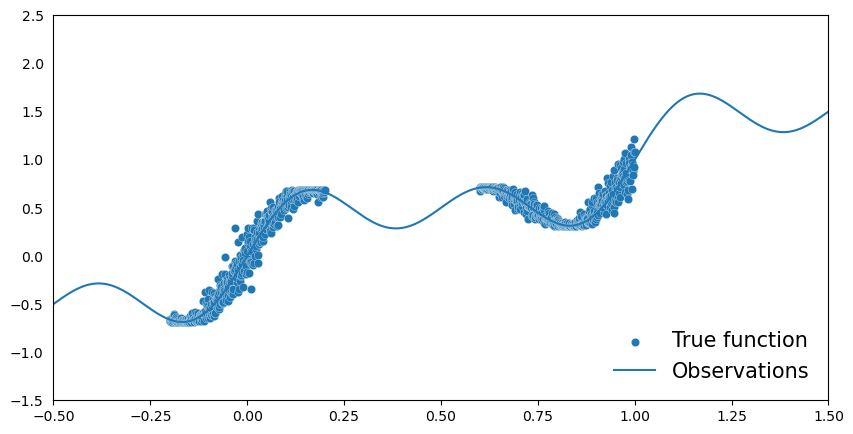

In [8]:
# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=x_obs, y=y_obs, linewidth=0.2, label="True function")
sns.lineplot(x=x_true, y=y_true, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.tick_params(left=False)
ax.legend(loc=4, fontsize=15, frameon=False)
plt.show()

In [12]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
import torch.nn as nn


class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None, dropout_prob=0.5):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
            x = self.dropout(layer(x))
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu


In [13]:
from pyro.infer import MCMC, NUTS

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# define model and data
model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)

# define MCMC sampler
#nuts_kernel = NUTS(model, jit_compile=False)
#mcmc = MCMC(nuts_kernel, num_samples=50)
#mcmc.run(x_train, y_train)

# SVI
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, None, optimizer, loss=Trace_ELBO())
num_iterations = 1000
for i in range(num_iterations):
    loss = svi.step(x_train, y_train)
    if i % 100 == 0:
        print(f"Iteration {i}, Loss = {loss:.4f}")

TypeError: TraceMessenger.get_trace() takes 1 positional argument but 3 were given

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [ ]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    sns.lineplot(x=x_true, y=y_true, label="true function")
    sns.scatterplot(x=x_obs, y=y_obs, label="observations")
    sns.lineplot(x=x_test, y=y_pred, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

In [ ]:
plot_predictions(preds)

In [ ]:
x_eval = torch.linspace(-0.2, 1, 1000)
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_eval = hidden_function(x_eval+noise)

In [ ]:
preds_eval = predictive(x_eval)
y_pred = preds_eval['obs'].T.detach().numpy().mean(axis=1)
y_std = preds_eval['obs'].T.detach().numpy().std(axis=1)

In [ ]:
y_pred_upper = y_pred + 2*y_std
y_pred_lower = y_pred - 2*y_std

y_within_bounds = np.logical_and(y_pred_lower <= y_eval.numpy(), y_eval.numpy() <= y_pred_upper)
print("Fraction 95% CI:", y_within_bounds.mean())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)
sns.scatterplot(x=x_eval, y=y_eval, hue=y_within_bounds)
sns.lineplot(x=x_true, y=y_true, label="true function")
sns.lineplot(x=x_eval, y=y_pred, color="#408765", label="predictive mean")
ax.fill_between(x_eval, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False)